<a href="https://colab.research.google.com/github/marcusvpimentel/Mestrado/blob/main/Forecasting_Vale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

! pip install yfinance #rode para instalar no Python/Google Colab

In [ ]:
import yfinance as yf      #importar a biblioteca yahoo finance
import datetime as dt      #importar biblioteca de data/tempo
import os
import csv                #importar biblioteca manipular planilhas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # Importar biblioteca de normalização
from tensorflow import keras  # Importar biblioteca Keras
from tensorflow.keras import layers

In [ ]:
# Definindo parâmetros
codigo_acao = "VALE"  # Substitua pelo código da ação desejada

# Baixando dados históricos da ação
dados = yf.download(codigo_acao)


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Salvando dados em um arquivo CSV
dados_acao.to_csv("dados_acao.csv", index=True)

count    3522.000000
mean       15.313833
std         7.461068
min         2.150000
25%        10.832500
50%        13.790000
75%        18.277501
max        37.080002
Name: Close, dtype: float64


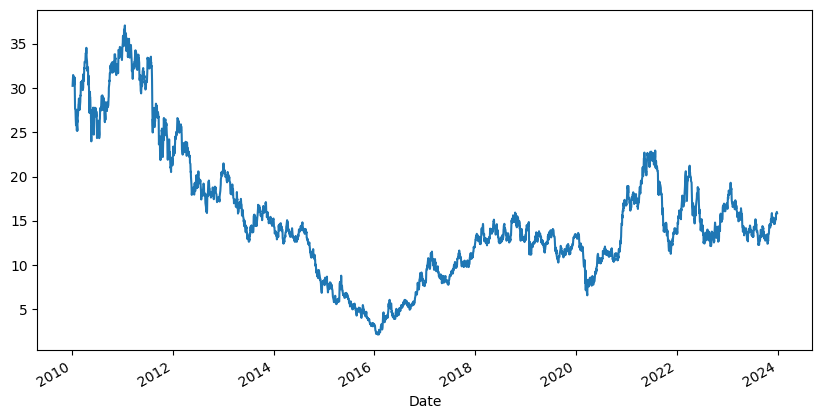

In [ ]:
# Análise descritiva dos preços de fechamento
print(dados_acao["Close"].describe())

# Visualização da série temporal de preços de fechamento
dados_acao["Close"].plot(figsize=(10, 5))
plt.show()

# Salvando dados em um arquivo CSV
dados_acao.to_csv("dados_acao_vale.csv", index=True)


In [ ]:
dados_acao.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,29.590000,30.280001,29.530001,30.250000,13.816658,19384000
2010-01-05,30.139999,31.020000,30.090000,30.570000,13.962815,24200200
2010-01-06,30.570000,31.430000,30.459999,31.059999,14.186622,24190900
2010-01-07,31.020000,31.170000,30.570000,31.150000,14.227731,16064900
2010-01-08,31.379999,31.879999,31.270000,31.480000,14.378455,14727200


In [202]:
fname = os.path.join("dados_acao_vale.csv")
with open(fname) as f:
  data = f.read()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))



['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
3523


In [ ]:
precos_fechamento = np.zeros(len(lines))
raw_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    if len(values) >= 4:  # Verifica se values tem pelo menos 4 elementos
        precos_fechamento[i] = values[3]
    if len(values) >= len(header)-1:  # Verifica se values tem pelo menos o número correto de elementos
        raw_data[i, :] = values[:len(header)-1]

In [ ]:
precos_fechamento

array([30.25      , 30.56999969, 31.05999947, ..., 15.89000034,
       15.85999966,  0.        ])

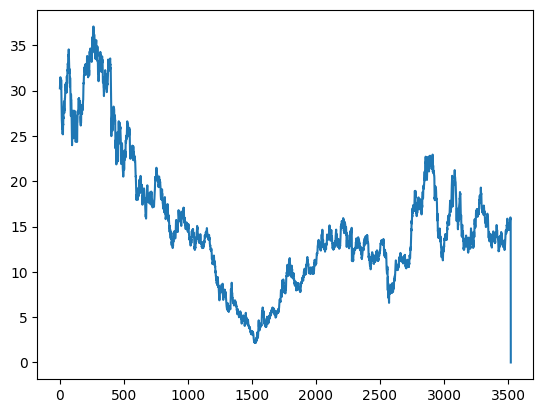

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(precos_fechamento)), precos_fechamento)

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
(num_train_samples, num_val_samples, num_test_samples)

(1761, 880, 882)

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
# Parametros
sampling_rate = 6
sequence_length = 50
delay = sampling_rate * (sequence_length + 24 + 1)
batch_size = 256

In [ ]:
def generate_dataset(data):
    train_dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets = precos_fechamento[delay:],
        sampling_rate = sampling_rate,
        sequence_length = sequence_length,
        shuffle = True,
        batch_size = batch_size,
        end_index = num_train_samples)
    val_dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets = precos_fechamento[delay:],
        sampling_rate = sampling_rate,
        sequence_length = sequence_length,
        shuffle = True,
        batch_size = batch_size,
        start_index = num_train_samples,
        end_index = num_train_samples + num_val_samples)
    test_dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets = precos_fechamento[delay:],
        sampling_rate = sampling_rate,
        sequence_length = sequence_length,
        shuffle = True,
        batch_size = batch_size,
        start_index = num_train_samples + num_val_samples)

    return train_dataset, val_dataset, test_dataset


In [ ]:
# Gerar conjuntos de dados
train_dataset , val_dataset, test_dataset  = generate_dataset(raw_data)

### Baseline

In [ ]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.26
Test MAE: 2.39


### Densely conected

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
6/6 [==============================] - 1s 57ms/step - loss: 125.7408 - mae: 9.9136 - val_loss: 128.9413 - val_mae: 11.1561
Epoch 2/10
6/6 [==============================] - 0s 27ms/step - loss: 65.6976 - mae: 6.8658 - val_loss: 114.8945 - val_mae: 10.5303
Epoch 3/10
6/6 [==============================] - 0s 38ms/step - loss: 44.4457 - mae: 5.2999 - val_loss: 108.2076 - val_mae: 10.2198
Epoch 4/10
6/6 [==============================] - 0s 30ms/step - loss: 34.4987 - mae: 4.5867 - val_loss: 102.1377 - val_mae: 9.9281
Epoch 5/10
6/6 [==============================] - 0s 28ms/step - loss: 29.7934 - mae: 4.3008 - val_loss: 101.5249 - val_mae: 9.8975
Epoch 6/10
6/6 [==============================] - 1s 74ms/step - loss: 27.0825 - mae: 4.1102 - val_loss: 99.9687 - val_mae: 9.8172
Epoch 7/10
6/6 [==============================] - 1s 75ms/step - loss: 24.7845 - mae: 3.9511 - val_loss: 98.9081 - val_mae: 9.7579
Epoch 8/10
6/6 [==============================] - 0s 38ms/step - loss: 22.

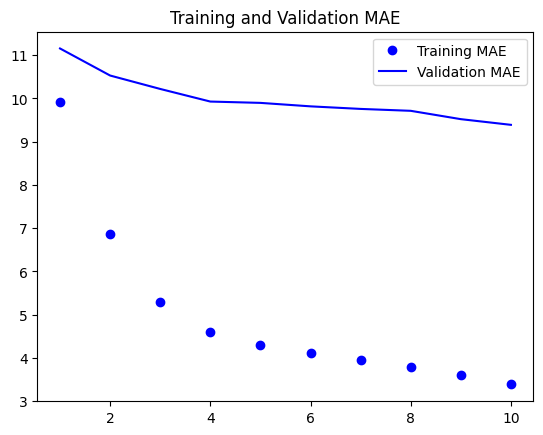

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

### LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
6/6 [==============================] - 3s 171ms/step - loss: 181.8862 - mae: 12.0365 - val_loss: 158.6379 - val_mae: 12.3982
Epoch 2/10
6/6 [==============================] - 0s 52ms/step - loss: 175.3309 - mae: 11.7910 - val_loss: 156.9545 - val_mae: 12.3320
Epoch 3/10
6/6 [==============================] - 1s 56ms/step - loss: 169.3907 - mae: 11.5625 - val_loss: 155.1171 - val_mae: 12.2583
Epoch 4/10
6/6 [==============================] - 0s 58ms/step - loss: 162.9263 - mae: 11.3259 - val_loss: 152.5269 - val_mae: 12.1528
Epoch 5/10
6/6 [==============================] - 1s 60ms/step - loss: 155.3907 - mae: 11.0353 - val_loss: 148.4041 - val_mae: 11.9823
Epoch 6/10
6/6 [==============================] - 0s 55ms/step - loss: 146.6672 - mae: 10.6747 - val_loss: 140.1745 - val_mae: 11.6334
Epoch 7/10
6/6 [==============================] - 0s 52ms/step - loss: 137.8005 - mae: 10.2639 - val_loss: 123.6621 - val_mae: 10.8873
Epoch 8/10
6/6 [==============================] - 0s 5

### dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
6/6 [==============================] - 4s 155ms/step - loss: 182.9068 - mae: 12.1105 - val_loss: 155.4862 - val_mae: 12.2634
Epoch 2/10
6/6 [==============================] - 1s 97ms/step - loss: 169.3878 - mae: 11.6815 - val_loss: 152.9341 - val_mae: 12.1563
Epoch 3/10
6/6 [==============================] - 1s 92ms/step - loss: 149.5904 - mae: 10.9318 - val_loss: 133.1619 - val_mae: 11.2833
Epoch 4/10
6/6 [==============================] - 1s 94ms/step - loss: 126.8949 - mae: 9.8193 - val_loss: 87.4526 - val_mae: 9.0363
Epoch 5/10
6/6 [==============================] - 1s 98ms/step - loss: 109.1095 - mae: 8.7154 - val_loss: 67.2408 - val_mae: 7.8626
Epoch 6/10
6/6 [==============================] - 1s 97ms/step - loss: 96.2021 - mae: 7.9100 - val_loss: 55.8961 - val_mae: 7.1183
Epoch 7/10
6/6 [==============================] - 1s 94ms/step - loss: 85.5362 - mae: 7.3355 - val_loss: 48.6034 - val_mae: 6.5927
Epoch 8/10
6/6 [==============================] - 1s 122ms/step - lo

### bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_bidirectional.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
6/6 [==============================] - 5s 231ms/step - loss: 180.8073 - mae: 11.8347 - val_loss: 151.9337 - val_mae: 12.1236
Epoch 2/10
6/6 [==============================] - 1s 73ms/step - loss: 171.4572 - mae: 11.5553 - val_loss: 151.3051 - val_mae: 12.0976
Epoch 3/10
6/6 [==============================] - 1s 70ms/step - loss: 164.0954 - mae: 11.3097 - val_loss: 149.4090 - val_mae: 12.0196
Epoch 4/10
6/6 [==============================] - 1s 119ms/step - loss: 157.1618 - mae: 11.0525 - val_loss: 146.3277 - val_mae: 11.8914
Epoch 5/10
6/6 [==============================] - 1s 123ms/step - loss: 150.1191 - mae: 10.7634 - val_loss: 142.2081 - val_mae: 11.7164
Epoch 6/10
6/6 [==============================] - 1s 139ms/step - loss: 142.6961 - mae: 10.4398 - val_loss: 136.3459 - val_mae: 11.4600
Epoch 7/10
6/6 [==============================] - 1s 73ms/step - loss: 134.8879 - mae: 10.0705 - val_loss: 129.0343 - val_mae: 11.1283
Epoch 8/10
6/6 [==============================] - 1

### 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks = callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
6/6 [==============================] - 1s 69ms/step - loss: 162.2621 - mae: 11.4085 - val_loss: 147.7012 - val_mae: 11.9491
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 110.1546 - mae: 9.4827 - val_loss: 132.6772 - val_mae: 11.3120
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 65.0123 - mae: 7.0314 - val_loss: 111.5890 - val_mae: 10.3541
Epoch 4/10
6/6 [==============================] - 0s 43ms/step - loss: 39.3195 - mae: 5.0244 - val_loss: 96.0084 - val_mae: 9.5871
Epoch 5/10
6/6 [==============================] - 0s 34ms/step - loss: 30.4776 - mae: 4.3750 - val_loss: 91.0229 - val_mae: 9.3289
Epoch 6/10
6/6 [==============================] - 0s 35ms/step - loss: 27.5359 - mae: 4.2078 - val_loss: 89.5709 - val_mae: 9.2505
Epoch 7/10
6/6 [==============================] - 0s 51ms/step - loss: 24.7902 - mae: 4.0062 - val_loss: 85.7344 - val_mae: 9.0383
Epoch 8/10
6/6 [==============================] - 1s 53ms/step - loss: 21.